In [1]:
import io
import sys
import glob
import xrft
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

# - Load data

In [2]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")

In [11]:
#  Dropping Aghulas scenarios for now
scenarios = [x for x in scenarios if not 'Aghulas' in x]
scenarios

['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Iceland_20231107_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Morroco_20201103_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Scotland_2

In [19]:
# for scenario


In [27]:
scenarios_train = [x for x in scenarios if 'Azores' not in x or 'Scotland' not in x]
scenarios_test = [x for x in scenarios if 'Azores'  in x or 'Scotland' in x]

n = 20 # number of azimuth cells to consider from center (e.g. total azimuth cells is 2*n +1)
spacing_slow_time = 2*n # pixels
spacing_ground_range = n # pixels


# --------------Training--------------
X_train = []
y_train = []
for scenario in scenarios_train:
    data = xr.open_dataset(scenario)
    scenario_inverse = scenario.replace('4ML_', '4ML_inverse_')
    data_inverse = xr.open_dataset(scenario_inverse)

    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
        data_inverse = data_inverse.reset_index('slow_time')
    except:
        pass

    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y = data.V_leakage_pulse_rg - data_inverse.V_leakage_pulse_rg
    y_data = xr.concat([y.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

    # Training
    X_train_spaced = X_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)
    y_train_spaced = y_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

    data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
    X_train.append(data_train.iloc[:,:-1])
    y_train.append(data_train.iloc[:,-1])

X_train = pd.concat(X_train)
y_train = pd.concat(y_train)


# --------------Testing--------------
X_test = []
y_test = []
for scenario in scenarios_test:
    data = xr.open_dataset(scenario)
    scenario_inverse = scenario.replace('4ML_', '4ML_inverse_')
    data_inverse = xr.open_dataset(scenario_inverse)
    
    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
        data_inverse = data_inverse.reset_index('slow_time')
    except:
        pass
    
    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y = data.V_leakage_pulse_rg - data_inverse.V_leakage_pulse_rg
    y_data = xr.concat([y.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

    X_test_pre = X_data.values.reshape(-1, 2*n+1)
    y_test_pre = y_data.values.reshape(-1)

    data_test = pd.DataFrame(np.column_stack((X_test_pre,y_test_pre))).dropna()
    X_test.append(data_test.iloc[:,:-1])
    y_test.append(data_test.iloc[:,-1])
                  

In [28]:
def warning_catcher(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return 

def warning_catcher2(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            result = function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return result

In [29]:
# Instantiate model and overwrite automated Train / Test split

ML = AutomatedRegression(
    X=X_train,           # NOTE these are overwritten 
    y=X_train,           # NOTE these are overwritten 
    n_trial=0,
    models_to_optimize=['bayesianridge', 'lightgbm', 'catboost', 'xgboost'],
    n_jobs=1,
    n_weak_models=0,
    reload_study=False,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_n_20_5Tr_2Te_v1/',
)

ML.X_test = X_test[0]
ML.X_train = X_train
ML.y_test = y_test[0]
ML.y_train = y_train 


# warning_catcher(ML.apply)
# ML.apply()

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [30]:
model = joblib.load('/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_n_20_5Tr_2Te_v1/stacked_model.joblib')

ML performance, RMSE: 0.381 m/s, median error: 0.048 m/s
Inversion performance, RMSE: 0.460 m/s, median error: 0.057 m/s
ML performance, RMSE: 0.260 m/s, median error: -0.012 m/s
Inversion performance, RMSE: 0.453 m/s, median error: 0.004 m/s


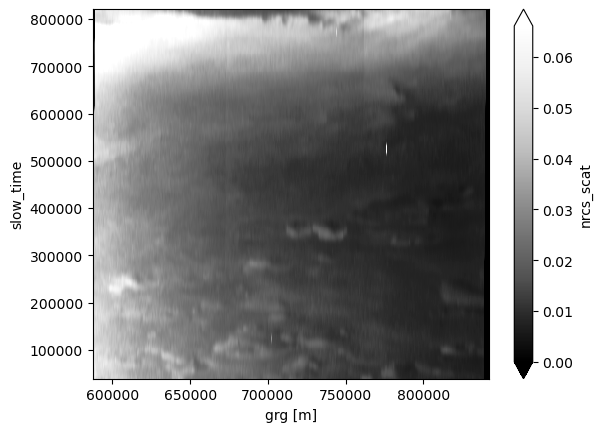

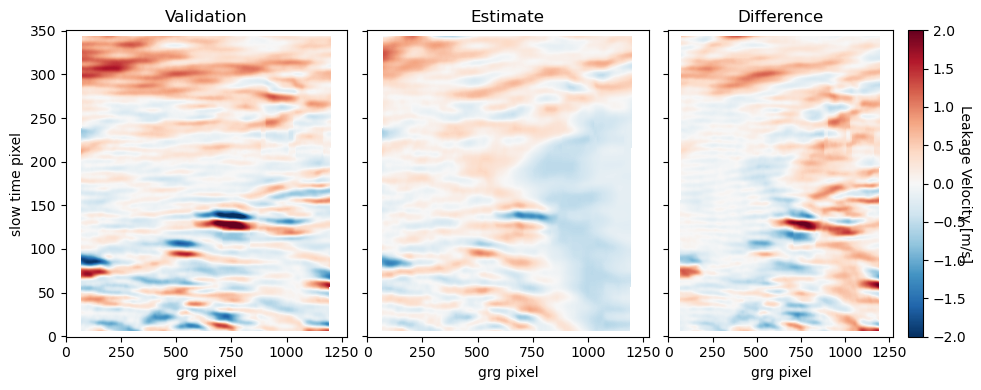

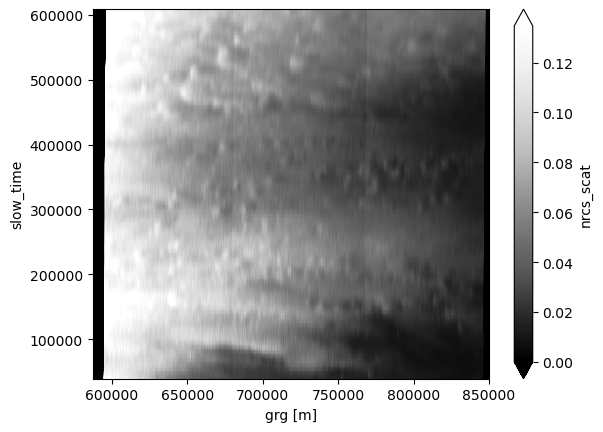

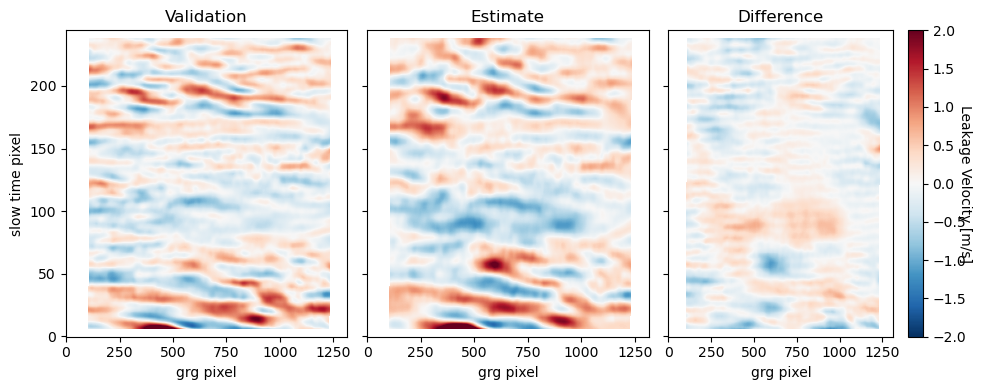

In [31]:
# plot estimation performance per test scenario 

for i, scenario in enumerate(scenarios_test):
    data = xr.open_dataset(scenario)
    plt.figure()
    data.nrcs_scat.T.plot(robust =True, vmin =0, cmap = 'Greys_r')
    scenario_inverse = scenario.replace('4ML_', '4ML_inverse_')
    data_inverse = xr.open_dataset(scenario_inverse)

    try:
        data = data.reset_index('slow_time')
        data_inverse = data_inverse.reset_index('slow_time')
    except:
        pass
    
    X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time')  for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
    y = data.V_leakage_pulse_rg_subscene - data_inverse.V_leakage_pulse_rg_subscene
    y_data = xr.concat([y.isel(slow_time=i) for i in range(n, len(y['slow_time'])-n)], dim='placeholder')


    y_pred = warning_catcher2(model.predict, X_test[i])
    y_shape = y_data.shape

    theoretical_length = y_data.values.reshape(-1).shape
    A = np.nan * np.arange(theoretical_length[0])
    A[y_test[i].index.values] = y_test[i].values
    A = A.reshape(y_shape)

    B = np.nan * np.arange(theoretical_length[0])
    B[y_test[i].index.values] = y_pred
    B = B.reshape(y_shape)

    ds = xr.Dataset(
        data_vars=dict(
            difference = ([ "slow_time", "grg"], A-B),
            original = ([ "slow_time", "grg"], A),
            new = ([ "slow_time", "grg"], B),
    ),
        coords=dict(
            slow_time=(["slow_time"], y_data.slow_time.values),
            grg=(["grg"], y_data.grg.values),
        ),
    )

    ds = ds.rolling(grg=data.attrs['grg_N'], slow_time=data.attrs['slow_time_N'], center=True).mean()

    perf_ML = np.sqrt(np.nanmean(ds.difference**2)), np.nanmedian(ds.difference)
    perf_inv = np.sqrt(np.nanmean(y**2)), np.nanmedian(y)

    print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
    print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")



    # ------------- plotting --------------# 
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

    vmin = -2;
    vmax = 2
    im0 = axes[0].imshow(ds.original, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im1 = axes[1].imshow(ds.new, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im2 = axes[2].imshow(ds.difference, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    [ax.set_xlabel('grg pixel') for ax in axes]
    axes[0].set_ylabel('slow time pixel')
    axes[0].set_title('Validation')
    axes[1].set_title('Estimate')
    axes[2].set_title('Difference')
    cbar = plt.colorbar(im0, ax=axes[2])
    cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
    fig.tight_layout()

## - Frequency domain analysis

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


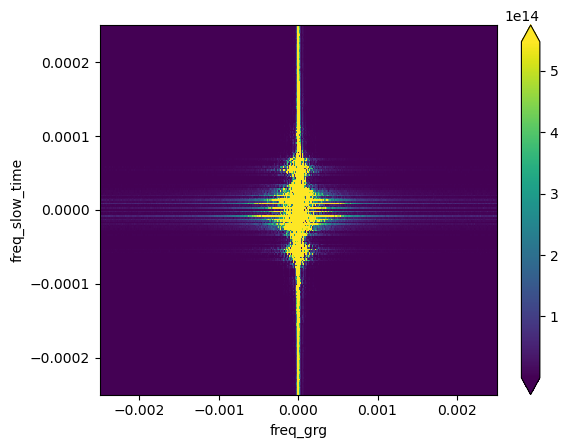

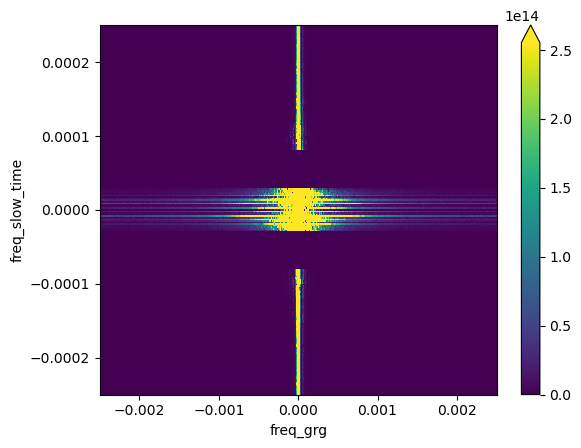

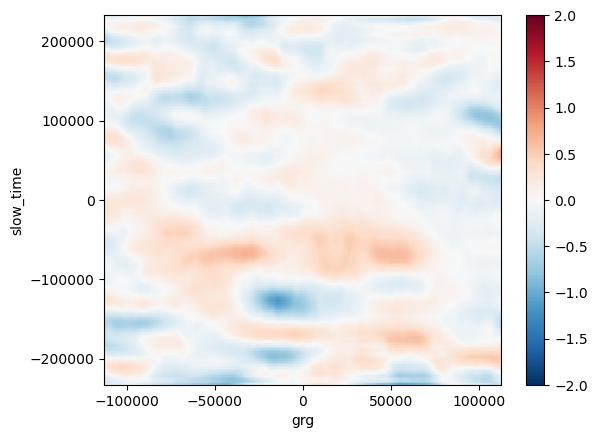

In [32]:
d4fft = ds.difference.dropna(dim ='slow_time', how = 'all').dropna(dim='grg')
d4fft = d4fft.assign_coords(
    {'slow_time':('slow_time',d4fft.slow_time.values - np.mean(d4fft.slow_time.values)),
    'grg':('grg',d4fft.grg.values - np.mean(d4fft.grg.values))}
    )

ps = xrft.fft(d4fft, window = 'boxcar')
ps_l = np.log10(ps)
plt.figure()
(abs(ps)**2).plot(robust = True)

condition = (abs(ps.freq_slow_time) < 8e-5) & (abs(ps.freq_slow_time) > 3e-5)

ps_f = xr.where(condition, 0,  ps)
plt.figure()
(abs(ps_f)**2).plot(robust = True)

inv = np.real(xrft.ifft(ps_f))
plt.figure()
inv.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')

In [36]:
print(f"RMSE before and after removal of incorrect noise frequencies: {perf_ML[0]:.3f} m/s & {np.sqrt(np.nanmean(inv**2)):.3f} m/s")

RMSE before and after removal of incorrect noise frequencies: 0.260 m/s & 0.245 m/s


## t-SNE presentation

In [82]:
from sklearn.manifold import TSNE

scene = -1 # NOTE only works for the most recent scene as y_pred is the last scenario run
indexes = 5000
X = X_test[scene].iloc[:indexes]
colour = (y_test[scene] - y_pred)[:indexes]

# Create a t-SNE model with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=42, perplexity=20)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = colour, s =  X.mean(axis=1))
plt.colorbar()
plt.title('t-SNE Visualization')
plt.show()

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

